<a href="https://colab.research.google.com/github/yuvanarvind/sleep-analysis/blob/main/Sleep_Analysis_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sleep Analysis - Final Project

### -Yuvan

In [66]:
!pip install pandas numpy scikit-learn shap matplotlib

In [67]:
import os
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import shap
import matplotlib.pyplot as plt
import joblib
pd.options.display.max_columns = 200


In [68]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading the dataset from Drive

In [69]:
import glob

DRIVE_BASE = "/content/drive/MyDrive/XAI"
RING_DATA_DIR = os.path.join(DRIVE_BASE, "ring_data")
OUTPUT_DIR = os.path.join(DRIVE_BASE, "sleep_xai_outputs")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Get all CSV files inside ring_data folder
csv_files = glob.glob(os.path.join(RING_DATA_DIR, "*.csv"))

print("Found files:", len(csv_files))
csv_files[:5]    # show first 5


Found files: 70


['/content/drive/MyDrive/XAI/ring_data/ring_data_2025_15.csv',
 '/content/drive/MyDrive/XAI/ring_data/ring_data_2025_38.csv',
 '/content/drive/MyDrive/XAI/ring_data/ring_data_2025_3.csv',
 '/content/drive/MyDrive/XAI/ring_data/ring_data_2025_39.csv',
 '/content/drive/MyDrive/XAI/ring_data/ring_data_2025_35.csv']

Load and combine all CSVs


In [70]:

df_list = []

for file in csv_files:
    temp_df = pd.read_csv(file)
    df_list.append(temp_df)

df_all = pd.concat(df_list, ignore_index=True)

print(df_all.shape)
df_all.head()


(602519, 3)


/tmp/ipython-input-3941686730.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat(df_list, ignore_index=True)


,timestamp_epoch,data_type,value
0,1743984143,raw_hr,113.0
1,1743984442,raw_hr,107.0
2,1743984742,raw_hr,104.0
3,1743985042,raw_hr,103.0
4,1743985343,raw_hr,99.0


In [71]:
# Load and combine all CSVs from ring_data directory
df_list = []
for file in csv_files:
    df_list.append(pd.read_csv(file))

df = pd.concat(df_list, ignore_index=True)   # <-- rename combined dataset to df


/tmp/ipython-input-369197677.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(df_list, ignore_index=True)   # <-- rename combined dataset to df


In [72]:
df.info()
df.describe(include='all')
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 602519 entries, 0 to 602518
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   timestamp_epoch  602519 non-null  object 
 1   data_type        602519 non-null  object 
 2   value            602519 non-null  float64
dtypes: float64(1), object(2)
memory usage: 13.8+ MB


Index(['timestamp_epoch', 'data_type', 'value'], dtype='object')

Pivot from long → wide format

In [73]:
# Pivot long → wide
df_wide = df.pivot(index="timestamp_epoch", columns="data_type", values="value").reset_index()

# Convert epoch to datetime
df_wide["timestamp"] = pd.to_datetime(df_wide["timestamp_epoch"], unit="s")

# Sort
df_wide = df_wide.sort_values("timestamp").reset_index(drop=True)

df_wide.head()


data_type,timestamp_epoch,raw_hr,raw_hrv_2,raw_motion,respiratory_rate,spo2,steps,temp,timestamp
0,1721041292,NaN,NaN,0.0,NaN,0.0,NaN,NaN,2024-07-15 11:01:32
1,1721041592,NaN,NaN,0.0,NaN,0.0,NaN,NaN,2024-07-15 11:06:32
2,1721041892,NaN,NaN,0.0,NaN,0.0,NaN,NaN,2024-07-15 11:11:32
3,1721042192,NaN,NaN,0.0,NaN,0.0,NaN,NaN,2024-07-15 11:16:32
4,1721042492,NaN,NaN,0.0,NaN,0.0,NaN,NaN,2024-07-15 11:21:32


Sort & Resample to 1-minute intervals

In [74]:
# Pivot long → wide
df_wide = df.pivot(index="timestamp_epoch", columns="data_type", values="value").reset_index()

# Convert epoch to datetime
df_wide["timestamp"] = pd.to_datetime(df_wide["timestamp_epoch"], unit="s")

# Sort
df_wide = df_wide.sort_values("timestamp").reset_index(drop=True)

df_wide.head()

# Use timestamp as index
df_wide = df_wide.set_index("timestamp")

# Resample to 1-minute intervals (fill missing values with forward-fill)
df_resampled = df_wide.resample("1T").mean().ffill().bfill()

df_resampled.head()


/tmp/ipython-input-3373624866.py:16: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled = df_wide.resample("1T").mean().ffill().bfill()


data_type,timestamp_epoch,raw_hr,raw_hrv_2,raw_motion,respiratory_rate,spo2,steps,temp
timestamp,,,,,,,,
2024-07-15 11:01:00,1.721041e+09,78.0,22.0,0.0,0.0,0.0,0.0,36.792912
2024-07-15 11:02:00,1.721041e+09,78.0,22.0,0.0,0.0,0.0,0.0,36.792912
2024-07-15 11:03:00,1.721041e+09,78.0,22.0,0.0,0.0,0.0,0.0,36.792912
2024-07-15 11:04:00,1.721041e+09,78.0,22.0,0.0,0.0,0.0,0.0,36.792912
2024-07-15 11:05:00,1.721041e+09,78.0,22.0,0.0,0.0,0.0,0.0,36.792912


In [75]:
# Rolling features (5-minute window)
df_resampled["hr_rolling"]   = df_resampled["raw_hr"].rolling(5).mean()
df_resampled["hrv_rolling"]  = df_resampled["raw_hrv_2"].rolling(5).mean()
df_resampled["motion_roll"]  = df_resampled["raw_motion"].rolling(5).mean()
df_resampled["temp_roll"]    = df_resampled["temp"].rolling(5).mean()
df_resampled["rr_roll"]      = df_resampled["respiratory_rate"].rolling(5).mean()


In [76]:
df_resampled["stillness_index"] = 1 / (1 + df_resampled["raw_motion"])


In [77]:
df_resampled["slowing_score"] = (
    (df_resampled["hr_rolling"].max() - df_resampled["hr_rolling"]) +
    (df_resampled["hrv_rolling"] - df_resampled["hrv_rolling"].min())
)


In [78]:
df_resampled["awake_flag"] = (df_resampled["steps"] > 0).astype(int)


In [79]:
df_resampled.tail()


data_type,timestamp_epoch,raw_hr,raw_hrv_2,raw_motion,respiratory_rate,spo2,steps,temp,hr_rolling,hrv_rolling,motion_roll,temp_roll,rr_roll,stillness_index,slowing_score,awake_flag
timestamp,,,,,,,,,,,,,,,,
2025-11-14 18:26:00,1.763145e+09,72.0,237.0,150.0,0.0,97.0,33.0,25.148438,72.0,237.0,150.0,24.848437,0.0,0.006623,357.0,1
2025-11-14 18:27:00,1.763145e+09,69.0,225.0,150.0,0.0,97.0,33.0,25.148438,71.4,234.6,150.0,24.948438,0.0,0.006623,355.2,1
2025-11-14 18:28:00,1.763145e+09,69.0,225.0,150.0,0.0,97.0,33.0,25.148438,70.8,232.2,150.0,25.048437,0.0,0.006623,353.4,1
2025-11-14 18:29:00,1.763145e+09,69.0,225.0,150.0,0.0,97.0,33.0,25.148438,70.2,229.8,150.0,25.148438,0.0,0.006623,351.6,1
2025-11-14 18:30:00,1.763145e+09,69.0,225.0,150.0,0.0,97.0,0.0,25.570312,69.6,227.4,150.0,25.232813,0.0,0.006623,349.8,0


## Sleep Score Formula
Normalize features (Z-score)

In [80]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

features_to_scale = [
    "hr_rolling", "hrv_rolling", "motion_roll",
    "rr_roll", "temp_roll"
]

df_scaled = df_resampled.copy()
df_scaled[features_to_scale] = scaler.fit_transform(df_scaled[features_to_scale])


Build a weighted sleep score

In [81]:
df_scaled["sleep_score_raw"] = (
    (-df_scaled["hr_rolling"] * 0.20) +
    ( df_scaled["hrv_rolling"] * 0.25) +
    (-df_scaled["motion_roll"] * 0.25) +
    (-df_scaled["rr_roll"] * 0.15) +
    (-df_scaled["temp_roll"] * 0.15)
)


Convert to a clean 0–100 scale

In [82]:
# Min-max scale to 0–100
score_min = df_scaled["sleep_score_raw"].min()
score_max = df_scaled["sleep_score_raw"].max()

df_scaled["sleep_score"] = (
    (df_scaled["sleep_score_raw"] - score_min) /
    (score_max - score_min)
) * 100


Check sleep_score

In [83]:
df_scaled[["sleep_score"]].describe()


data_type,sleep_score
count,701726.000000
mean,55.949896
std,10.151686
min,0.000000
25%,49.638054
50%,54.734829
75%,62.565341
max,100.000000


Select Features & Prepare Train/Test Data

In [84]:
#Select features and target
feature_cols = ["hr_rolling", "hrv_rolling", "motion_roll", "rr_roll", "temp_roll"]
target_col = "sleep_score"

X = df_scaled[feature_cols]
y = df_scaled[target_col]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X.shape, y.shape


((701730, 5), (701730,))

Train a Simple, Interpretable Model

In [85]:
#Train a Random Forest model
# Drop rows where sleep_score is NaN
df_model = df_scaled.dropna(subset=["sleep_score"])

# Then drop/fill remaining NaNs in features
df_model = df_model.fillna(method="ffill").fillna(method="bfill")

# Redefine X and y cleanly
X = df_model[feature_cols]
y = df_model[target_col]

# Train/test split again
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X.shape, y.shape



/tmp/ipython-input-3623917973.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_model = df_model.fillna(method="ffill").fillna(method="bfill")


((701726, 5), (701726,))

In [86]:
#Train a Random Forest model
model = RandomForestRegressor(
    n_estimators=200,
    max_depth=6,
    random_state=42
)

model.fit(X_train, y_train)

print("Sleep Model trained!")


Sleep Model trained!


Evaluate the Model (RMSE + R²)

In [87]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Predictions
y_pred = model.predict(X_test)

# RMSE (manual)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# R2
r2 = r2_score(y_test, y_pred)

print("Model Performance:")
print(f"RMSE: {rmse:.3f}")
print(f"R²:   {r2:.3f}")


Model Performance:
RMSE: 3.404
R²:   0.888


Generate SHAP values

In [88]:
#Initialize SHAP explainer
explainer = shap.TreeExplainer(model)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

print("SHAP values computed!")


SHAP values computed!


SHAP Summary Plot

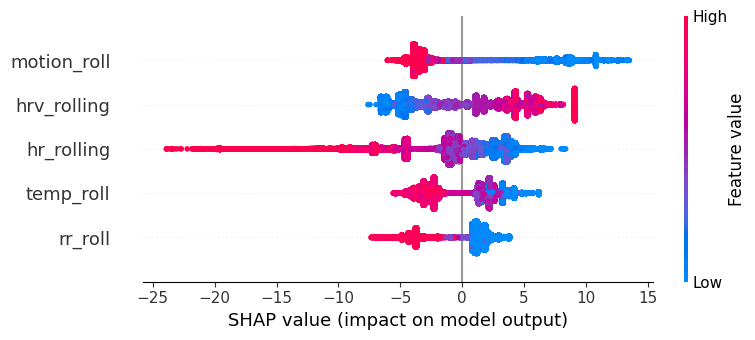

In [89]:
shap.summary_plot(shap_values, X_test)


Convert SHAP values into confidence percentages


In [92]:
# Pick any example row from X_test
x_single = X_test.iloc[[0]]

# Compute SHAP values for that row
shap_single = explainer.shap_values(x_single)[0]
feature_names = X_test.columns.tolist()
shap_abs = np.abs(shap_single)

# Normalize to percentages
confidence_scores = shap_abs / shap_abs.sum() * 100

# Create a readable table
explanation_df = pd.DataFrame({
    "feature": feature_names,
    "shap_value": shap_single,
    "confidence_percent": confidence_scores
}).sort_values("confidence_percent", ascending=False)

explanation_df


,feature,shap_value,confidence_percent
4,temp_roll,-4.086572,24.922944
1,hrv_rolling,-3.993042,24.352525
2,motion_roll,-3.727675,22.734125
0,hr_rolling,3.559982,21.711409
3,rr_roll,1.029556,6.278997


Final Human interpretable text

In [93]:
#Build a natural language explanation

# Get predicted sleep score for this sample
predicted_score = model.predict(x_single)[0]

explanation_lines = []
for idx, row in explanation_df.iterrows():
    feature = row["feature"]
    direction = "increased" if row["shap_value"] > 0 else "decreased"
    percent = round(row["confidence_percent"], 1)

    explanation_lines.append(
        f"- {percent}% confidence: {feature} {direction} your sleep score"
    )

final_explanation = (
    f"Predicted Sleep Score for this night: {predicted_score:.1f}/100\n\n"
    "What affected your sleep the most:\n" +
    "\n".join(explanation_lines)
)

print(final_explanation)


Predicted Sleep Score for this night: 48.7/100

What affected your sleep the most:
- 24.9% confidence: temp_roll decreased your sleep score
- 24.4% confidence: hrv_rolling decreased your sleep score
- 22.7% confidence: motion_roll decreased your sleep score
- 21.7% confidence: hr_rolling increased your sleep score
- 6.3% confidence: rr_roll increased your sleep score


Compute Baselines & Bedtime proxy

In [94]:
#Compute baseline HR and HRV for comparisons
baseline_hr = df_scaled["hr_rolling"].median()
baseline_hrv = df_scaled["hrv_rolling"].median()


In [95]:
# Late bedtime proxy
df_scaled["bedtime_proxy"] = df_scaled.index.hour

Caffeine proxy (evening HR + motion)

In [96]:
# Caffeine proxy (evening HR + motion)
df_scaled["caffeine_proxy"] = (
    df_scaled["hr_rolling"] * (df_scaled.index.hour >= 18)
    +
    df_scaled["motion_roll"] * (df_scaled.index.hour >= 18)
)


Alcohol Proxy

In [97]:
# Alcohol proxy
df_scaled["alcohol_proxy"] = (
    (df_scaled["temp_roll"] - df_scaled["temp_roll"].median()) +
    (df_scaled["hr_rolling"] - baseline_hr) -
    (df_scaled["hrv_rolling"] - baseline_hrv)
)


Stress Proxy

In [98]:
# Stress proxy
df_scaled["stress_proxy"] = (
    (df_scaled["hr_rolling"] / baseline_hr) -
    (df_scaled["hrv_rolling"] / baseline_hrv)
)


Update the Model to Include the 5 Lifestyle Proxies -- Defining new features set :)

In [99]:
df_scaled.columns


Index(['timestamp_epoch', 'raw_hr', 'raw_hrv_2', 'raw_motion',
       'respiratory_rate', 'spo2', 'steps', 'temp', 'hr_rolling',
       'hrv_rolling', 'motion_roll', 'temp_roll', 'rr_roll', 'stillness_index',
       'slowing_score', 'awake_flag', 'sleep_score_raw', 'sleep_score',
       'bedtime_proxy', 'caffeine_proxy', 'alcohol_proxy', 'stress_proxy'],
      dtype='object', name='data_type')

In [100]:
# Recreate activity proxy safely
if "steps" in df_scaled.columns:
    df_scaled["activity_proxy"] = df_scaled["steps"].fillna(0)
else:
    print("WARNING: 'steps' column missing!")

In [101]:
"activity_proxy" in df_scaled.columns


True

In [102]:
# Updated feature list (physiology + lifestyle)
feature_cols = [
    "hr_rolling",
    "hrv_rolling",
    "motion_roll",
    "rr_roll",
    "temp_roll",
    "bedtime_proxy",
    "caffeine_proxy",
    "alcohol_proxy",
    "stress_proxy",
    "activity_proxy"
]

# Prepare data
X = df_scaled[feature_cols]
y = df_scaled["sleep_score"]

# Clean missing values again (safety)
X = X.fillna(method="ffill").fillna(method="bfill")
y = y.fillna(method="ffill").fillna(method="bfill")

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X.shape, y.shape


/tmp/ipython-input-1448683684.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method="ffill").fillna(method="bfill")
/tmp/ipython-input-1448683684.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = y.fillna(method="ffill").fillna(method="bfill")


((701730, 10), (701730,))

In [103]:
feature_cols = [
    "hr_rolling",
    "hrv_rolling",
    "motion_roll",
    "rr_roll",
    "temp_roll",
    "bedtime_proxy",
    "caffeine_proxy",
    "alcohol_proxy",
    "stress_proxy",
    "activity_proxy"
]

X = df_scaled[feature_cols]
y = df_scaled["sleep_score"]

X = X.fillna(method="ffill").fillna(method="bfill")
y = y.fillna(method="ffill").fillna(method="bfill")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X.shape, y.shape


/tmp/ipython-input-3441093777.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method="ffill").fillna(method="bfill")
/tmp/ipython-input-3441093777.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = y.fillna(method="ffill").fillna(method="bfill")


((701730, 10), (701730,))

Retrain model with new physiology + lifestyle features

In [104]:
# Retrain model with new physiology + lifestyle features
model = RandomForestRegressor(
    n_estimators=300,
    max_depth=7,
    random_state=42
)

model.fit(X_train, y_train)

print("Model retrained with lifestyle features!")


Model retrained with lifestyle features!


Compute SHAP Values for the New Model

In [105]:
# New SHAP explainer for lifestyle model
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

print("SHAP values updated for lifestyle model!")


SHAP values updated for lifestyle model!


New SHAP summary plot

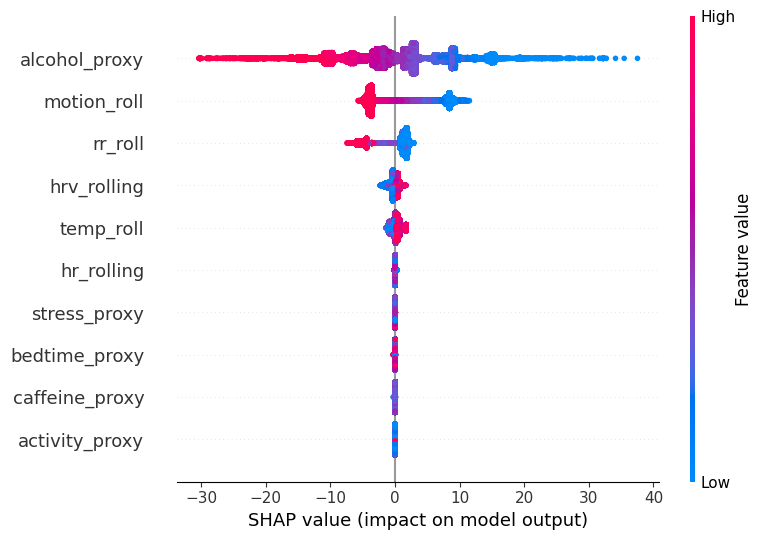

In [106]:
shap.summary_plot(shap_values, X_test)


Narrative Explanation

In [116]:
# Choose a date you want to explain
date_str = "2025-11-8"   # <-- change this to any date in your dataset

target_date = pd.to_datetime(date_str).date()

# Filter rows in X_test that belong to that calendar date
mask = X_test.index.date == target_date
X_test_for_date = X_test[mask]

X_test_for_date.head()


data_type,hr_rolling,hrv_rolling,motion_roll,rr_roll,temp_roll,bedtime_proxy,caffeine_proxy,alcohol_proxy,stress_proxy,activity_proxy
timestamp,,,,,,,,,,
2025-11-08 08:17:00,0.395889,1.162805,0.729714,-0.622446,0.880371,8,0.000000,0.220118,-13.390481,35.0
2025-11-08 07:19:00,-0.665368,1.236634,0.729714,-0.622446,0.603454,7,0.000000,-1.191885,-7.226699,0.0
2025-11-08 09:35:00,-0.235492,1.263978,0.729714,-0.622446,0.515162,9,0.000000,-0.877645,-10.256848,41.0
2025-11-08 04:34:00,0.530226,1.291322,0.729714,-0.622446,0.964985,4,0.000000,0.310550,-15.455253,24.0
2025-11-08 23:17:00,1.389978,-0.439558,0.729714,-0.622446,0.419847,23,2.119692,2.356045,-4.878362,27.0


In [117]:
# Pick first row from that date to explain
if len(X_test_for_date) == 0:
    print("No data in X_test for that date. Try another date.")
else:
    x_single = X_test_for_date.iloc[[0]]  # first row for that date
    print("Using this timestamp for explanation:", x_single.index[0])


Using this timestamp for explanation: 2025-11-08 08:17:00


In [118]:
# SHAP values for the selected date's row

shap_single = explainer.shap_values(x_single)[0]

# absolute shap values → determine confidence
shap_abs = np.abs(shap_single)
confidence_scores = shap_abs / shap_abs.sum() * 100

# Build the explanation dataframe
explanation_df = pd.DataFrame({
    "feature": X_test.columns,
    "shap_value": shap_single,
    "confidence_percent": confidence_scores
}).sort_values("confidence_percent", ascending=False)

explanation_df


,feature,shap_value,confidence_percent
2,motion_roll,-3.916556e+00,42.145132
3,rr_roll,1.714899e+00,18.453622
4,temp_roll,1.702702e+00,18.322370
7,alcohol_proxy,-1.689364e+00,18.178851
1,hrv_rolling,2.656260e-01,2.858339
0,hr_rolling,-3.864079e-03,0.041580
5,bedtime_proxy,7.328703e-06,0.000079
9,activity_proxy,-2.140550e-06,0.000023
8,stress_proxy,2.138932e-07,0.000002
6,caffeine_proxy,-1.689982e-07,0.000002


In [119]:
# User-friendly narrative explanation for the selected date

# Predicted sleep score for this date
pred_score = model.predict(x_single)[0]

# Map features to friendly names
name_map = {
    "bedtime_proxy": "your bedtime",
    "caffeine_proxy": "caffeine or stimulation before sleep",
    "alcohol_proxy": "alcohol-like physiological effects",
    "stress_proxy": "your stress level",
    "activity_proxy": "your physical activity",

    "hr_rolling": "your nighttime heart rate",
    "hrv_rolling": "your HRV",
    "motion_roll": "your restlessness",
    "rr_roll": "your breathing rate",
    "temp_roll": "your body temperature"
}

# Build explanation lines
user_lines = []
for _, row in explanation_df.iterrows():
    feature = row["feature"]
    percent = round(row["confidence_percent"], 1)
    direction = "improved" if row["shap_value"] > 0 else "reduced"
    readable = name_map.get(feature, feature.replace("_", " "))

    user_lines.append(f"- {percent}% confidence → {readable} **{direction}** your sleep score")

# Build the final narrative
narrative = f"""
### Sleep Score Analysis for {date_str}

Your predicted sleep score for this night is **{pred_score:.1f}/100**.

Here’s what influenced your sleep the most:

{chr(10).join(user_lines)}

---

### Interpretation

These percentages show how strongly each factor contributed to your sleep score.
Higher percentages mean greater influence — positive or negative.

Lifestyle factors and physiological responses combine to form your nightly recovery:
- Stress raises heart rate & lowers HRV
- Caffeine elevates evening HR & delays sleep onset
- Alcohol elevates temperature & suppresses HRV
- Late bedtime shifts circadian alignment
- Activity improves sleep drive
- Physiological signals (HR, HRV, temperature, motion, breathing) show how your body responded


### Personalized Suggestions

"""

# Auto-suggestions based on negative contributors
for _, row in explanation_df.iterrows():
    feature = row["feature"]
    shap_val = row["shap_value"]

    if shap_val < 0:
        if feature == "stress_proxy":
            narrative += "- Try calming down pre-bedtime — your body showed nighttime stress.\n"
        elif feature == "caffeine_proxy":
            narrative += "- Reduce caffeine 6–8 hours before sleep — stimulant patterns were detected.\n"
        elif feature == "alcohol_proxy":
            narrative += "- Alcohol-like physiological markers appeared; these often hurt HRV.\n"
        elif feature == "bedtime_proxy":
            narrative += "- Your bedtime was later than your ideal rhythm.\n"
        elif feature == "activity_proxy":
            narrative += "- Low daytime activity reduced your sleep drive.\n"
        elif feature == "hr_rolling":
            narrative += "- Elevated heart rate reduced deep sleep potential.\n"
        elif feature == "hrv_rolling":
            narrative += "- Lower HRV indicates your recovery was impaired.\n"
        elif feature == "motion_roll":
            narrative += "- You experienced restlessness during sleep.\n"
        elif feature == "temp_roll":
            narrative += "- Higher temperature indicates stress, alcohol, or late meals.\n"

print(narrative)


### Sleep Score Analysis for 2025-11-8

Your predicted sleep score for this night is **54.0/100**.

Here’s what influenced your sleep the most:

- 42.1% confidence → your restlessness **reduced** your sleep score
- 18.5% confidence → your breathing rate **improved** your sleep score
- 18.3% confidence → your body temperature **improved** your sleep score
- 18.2% confidence → alcohol-like physiological effects **reduced** your sleep score
- 2.9% confidence → your HRV **improved** your sleep score
- 0.0% confidence → your nighttime heart rate **reduced** your sleep score
- 0.0% confidence → your bedtime **improved** your sleep score
- 0.0% confidence → your physical activity **reduced** your sleep score
- 0.0% confidence → your stress level **improved** your sleep score
- 0.0% confidence → caffeine or stimulation before sleep **reduced** your sleep score

---

### Interpretation

These percentages show how strongly each factor contributed to your sleep score.
Higher percentages mean gre

Saving outputs to a file in the sleep_xai_outputs folder

In [128]:
df_scaled.to_csv(
    "/content/drive/MyDrive/XAI/sleep_xai_outputs/df_scaled.csv"
)

print("Saved df_scaled.csv")

Saved df_scaled.csv


In [125]:
joblib.dump(
    model,
    "/content/drive/MyDrive/XAI/sleep_xai_outputs/model.pkl"
)

print("Saved model.pkl")

Saved model.pkl


In [126]:
joblib.dump(
    explainer,
    "/content/drive/MyDrive/XAI/sleep_xai_outputs/explainer.pkl"
)

print("Saved explainer.pkl")

Saved explainer.pkl


In [127]:
import json

with open("/content/drive/MyDrive/XAI/sleep_xai_outputs/feature_cols.json", "w") as f:
    json.dump(feature_cols, f)

print("Saved feature_cols.json")

Saved feature_cols.json


In [123]:
df_scaled.columns


Index(['timestamp_epoch', 'raw_hr', 'raw_hrv_2', 'raw_motion',
       'respiratory_rate', 'spo2', 'steps', 'temp', 'hr_rolling',
       'hrv_rolling', 'motion_roll', 'temp_roll', 'rr_roll', 'stillness_index',
       'slowing_score', 'awake_flag', 'sleep_score_raw', 'sleep_score',
       'bedtime_proxy', 'caffeine_proxy', 'alcohol_proxy', 'stress_proxy',
       'activity_proxy'],
      dtype='object', name='data_type')